# Vertically integrated salinity budget in ACCESS-OM2

This notebook contains a quick analysis of the Vertically integrated salinity budget in ACCESS-OM2

## Background Theory and diagnostics

### ACCESS-OM2 "Eulerian" salt budget


\begin{align}
  \textit{salt\_tendency} = &\textit{salt\_advection} + \\ &\quad +
  \textit{salt\_submeso} \\ &\quad + \textit{salt\_vdiffuse\_diff\_cbt}  + \textit{salt\_nonlocal\_KPP} \\ &\quad +
  \textit{salt\_rivermix} + \textit{salt\_vdiffuse\_sbc} \\
   & \quad + \textit{salt\_vdiffuse\_k33} + \textit{neutral\_diffusion\_salt}\\
   & \quad + \textit{neutral\_gm\_salt} \\
   & \quad + \textit{mixdownslope\_salt} + \textit{salt\_sigma\_diff} + \textit{salt\_eta\_smooth}
\end{align}

All terms are in units of kg m$^{-2}$ sec$^{-1}$ - i.e. the tendency of the salt content (in kg) within each grid cell per unit area, $\rho_0 S_A \Delta z$, where $\Delta z$ is the time variable grid cell thickness, $\rho_0=1035$kgm$^{-3}$ is the reference density and $S_A$ is Absolute Salinity in units of kg/kg.

- salt\_tendency is the tendency term
- salt\_advection is the convergence of the three-dimensional resolved advection (this can be split into components by taking the convergence of the salt\_xflux\_adv, salt\_yflux\_adv and salt\_zflux\_adv terms)
- salt\_submeso is the convergence of the three-dimensional parameterized submesoscale advection (pretty small).
- salt\_vdiffuse\_diff\_cbt and salt\_nonlocal\_KPP are the vertical mixing terms.
- The next line contains all of the surface salt flux terms. Note that as the budget is formulated as a salt budget, these are surface *salt* fluxes (and thus pretty small). Precipitation and evaporation are not explicitly represented in this budget because they do not add or subtract salt from the ocean.
- salt\_rivermix is also three-dimensional as the impact of river runoff is spread over a few layers (4 I think). The other terms are two-dimensional (only non-zero in the surface layer).
- salt\_vdiffuse\_k33 and neutral\_diffusion\_salt are parameterized along-isopycnal mixing (might not be on in all configurations, e.g. ACCESS-OM2-01).
- neutral\_gm\_salt is parameterization advection by mesoscale eddies
- The last line includes some miscellaneous mixing terms (all pretty small, and not all active depending on configuration).

Also see https://github.com/COSIMA/access-om2/issues/139#issuecomment-639278547 for a discussion of the surface heat flux terms in ACCESS-OM2/CM2. There are some cells below which check this budget closure.

### Vertically-integrated salt budget

At each grid cell write the model salt budget above as

$$\frac{\partial (\rho_0 S \Delta z)}{\partial t} = \textit{salt\_tendency} = \sum_i P_i$$

Where $P_i$ are the RHS processes. Units are kg m$^{-2}$ sec$^{-1}$. Summing (where we use an integral sign for simplicity) over the full depth of the ocean (from $z=-H$ to $z=\eta$) gives,

$$\int_{-H}^\eta \frac{\partial (\rho_0 S \Delta z)}{\partial t} = \int_{-H}^\eta \sum_i P_i$$

Since the integral sign just represents a sum in discrete-land, we can just move the time integral outside:

$$\frac{\partial}{\partial t} \int_{-H}^\eta (\rho_0 S \Delta z) = \int_{-H}^\eta \sum_i P_i$$

Now, setting $\int_{-H}^\eta (\rho_0 S \Delta z) = \rho_0 \overline{S} (\eta-H)$, where $\overline{S}$ is the vertically-averaged salinity. We thus have:
\begin{align*}
    \frac{\partial \left(\rho_0 \overline{S}(\eta-H)\right)}{\partial t} &= \int_{-H}^\eta \sum_i P_i \\
    \Longrightarrow \frac{\partial \overline{S}}{\partial t} + \frac{\overline{S}}{\eta-H}\frac{\partial \eta}{\partial t} &= \frac{1}{\rho_0 (\eta-H)}\int_{-H}^\eta \sum_i P_i
\end{align*}

Now, we can write the tendency of the sea level as something like:

$$\frac{\partial \eta}{\partial t} = F + \nabla_H\cdot\mathbf{U}$$

Where $F$ is the net surface volume flux (ms$^{-1}$), $\mathbf{U}$ is the vertically-integrated lateral volume transport (m$^2$s$^{-1}$) and $\nabla_H\cdot$ is the horizontal divergence operator. The terms in this equation can all be computed - the LHS from snapshots of the sea level at the beginning and ending of our time period of interest, the $F$ term from the `pme_river` diagnostic and the last term from the `tx_trans_int_z` and `ty_trans_int_z` diagnostics. We can then write the total budget for $\overline{S}$ as:

$$\frac{\partial \overline{S}}{\partial t} = -\frac{\overline{S}}{\eta-H} F-\frac{\overline{S}}{\eta-H} \nabla_H\cdot\mathbf{U} + \frac{1}{\rho_0 (\eta-H)}\int_{-H}^\eta \sum_i P_i$$

Here, we now have $F$ entering explicitly, through its dilution of the vertically averaged salinity as the first term on the RHS.

The second term on the right should be combined with the advection term within $P_i$. Taking some liberties with notation:

$$-\frac{\overline{S}}{\eta-H} \nabla_H\cdot\mathbf{U} + \frac{1}{\rho_0 (\eta-H)}\int_{-H}^\eta \nabla_H\cdot\left(\mathbf{u} \rho_0 S \Delta z\right) = \frac{1}{\eta - H}\int_{-H}^\eta \nabla_H\cdot\left(\mathbf{u} S \Delta z\right) - \overline{S}\nabla_H\cdot\left(\mathbf{u} \Delta z\right)$$

The second term on the LHS is the salt advection diagnostic. The RHS shows that the combination of this term with the vertically-integrated divergence term from the sea level tendency gives a term effectively related to the advection of salinity *deviations* from the vertical mean. I.e. The vertically-integrated salinity is changed by advection when salinity that differs from the vertical-average is advected into the given water column.

Below we attempt to interogate this budget.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from tqdm import tqdm

import cmocean as cm
import sys, os

from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=4)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45021 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:34441' processes=4 threads=4, memory=18.00 GiB>

In [3]:
# Chdir for figure saving:
os.chdir('access-om2-analysis/cosima-scripts/Salinity')

# Load datasets:

In [10]:
base = '/scratch/e14/rmh561/access-om2/archive/025deg_jra55_iaf/'
output = 372
base2 = base + 'output%03d/ocean/' % output
rho0 = 1035.

reg = [-100, 20, 0, 60]
times = slice(0,None)
times_snap = None # slice(0,None) # Must be either None (for using all times and previous output), or 1 more than times.

In [11]:
# monthly data:
ds_month = xr.open_dataset(base2 + 'ocean_month.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))#.isel(time=times)
ds_grid = xr.open_dataset(base2 + 'ocean_grid.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))#.isel(time=times)
ds_mon_budget = xr.open_dataset(base2 + 'ocean_budget.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))#.isel(time=times)

if times_snap is None:
    # Add snapshot from previous output:
    ds_mon_snapshot = xr.open_dataset(base2 + 'ocean_snapshot.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
    ds_mon_snapshot_m1 = xr.open_dataset(base2.replace(str(output),str(output-1)) + 'ocean_snapshot.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
    ds_mon_snapshot = xr.concat([ds_mon_snapshot_m1.isel(time=-1),ds_mon_snapshot],dim='time')
else:
    ds_mon_snapshot = xr.open_dataset(base2 + 'ocean_snapshot.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))#.isel(time=times_snap)

In [5]:
# daily data:
ds_day_budget = xr.open_dataset(base2 + 'ocean_budget_daily.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
ds_day = xr.open_dataset(base2 + 'ocean_daily.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))

# Add snapshot from previous output:
ds_day_snapshot = xr.open_dataset(base2 + 'ocean_snapshot_daily.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
ds_day_snapshot_m1 = xr.open_dataset(base2.replace(str(output),str(output-1)) + 'ocean_snapshot_daily.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
ds_day_snapshot = xr.concat([ds_day_snapshot_m1.isel(time=-1),ds_day_snapshot],dim='time')

# NOTE: THere is some bug with the time variable in the daily data - it is offset by a few days. Probably because of some issue with the OMIP time cycling.
# It doesn't make a difference for the below calculations (since I'm averaging over a full run cycle, so daily and monthly stuff will match anyway).
# However, it is important to be aware of.

# Check that raw budget terms close

## Raw Eulerian salt budget:

In [6]:
# Choose time, region, depth:
time = 0; reg_slice= [-300, 300,-90,90]; st_ocean = 0;

# Load budget:
ds_budget_slice = xr.open_dataset(base2 + 'ocean_budget.nc').sel(xt_ocean=slice(reg_slice[0],reg_slice[1]),yt_ocean=slice(reg_slice[2],reg_slice[3])).isel(time=time).isel(st_ocean=st_ocean)

# List the terms:
bud_vars = ['salt_advection','salt_submeso','neutral_diffusion_salt','neutral_gm_salt','salt_vdiffuse_k33',
            'salt_nonlocal_KPP','salt_vdiffuse_diff_cbt',
            'salt_rivermix','salt_vdiffuse_sbc']

# Add the 2D terms if we're looking at the surface layer:
if st_ocean == 0:
    bud_vars = bud_vars + ['salt_eta_smooth']

# Compute the residual:
ds_budget_slice['residual'] = ds_budget_slice.salt_tendency.load().copy(deep=True)
for var in bud_vars:
    ds_budget_slice['residual'] -= ds_budget_slice[var].load()

# Add tendency and residual to the terms list:
bud_vars = ['salt_tendency','residual'] + bud_vars

Spatial maximums of terms (10^-7 kgm-2sec-1):
 167.72747,  salt_tendency
   0.00141,  residual
12533.34573,  salt_advection
 252.49303,  salt_submeso
 418.40125,  neutral_diffusion_salt
  42.38775,  neutral_gm_salt
   0.00000,  salt_vdiffuse_k33
3050.85094,  salt_nonlocal_KPP
2717.95521,  salt_vdiffuse_diff_cbt
12176.75162,  salt_rivermix
  84.98965,  salt_vdiffuse_sbc
1146.74498,  salt_eta_smooth


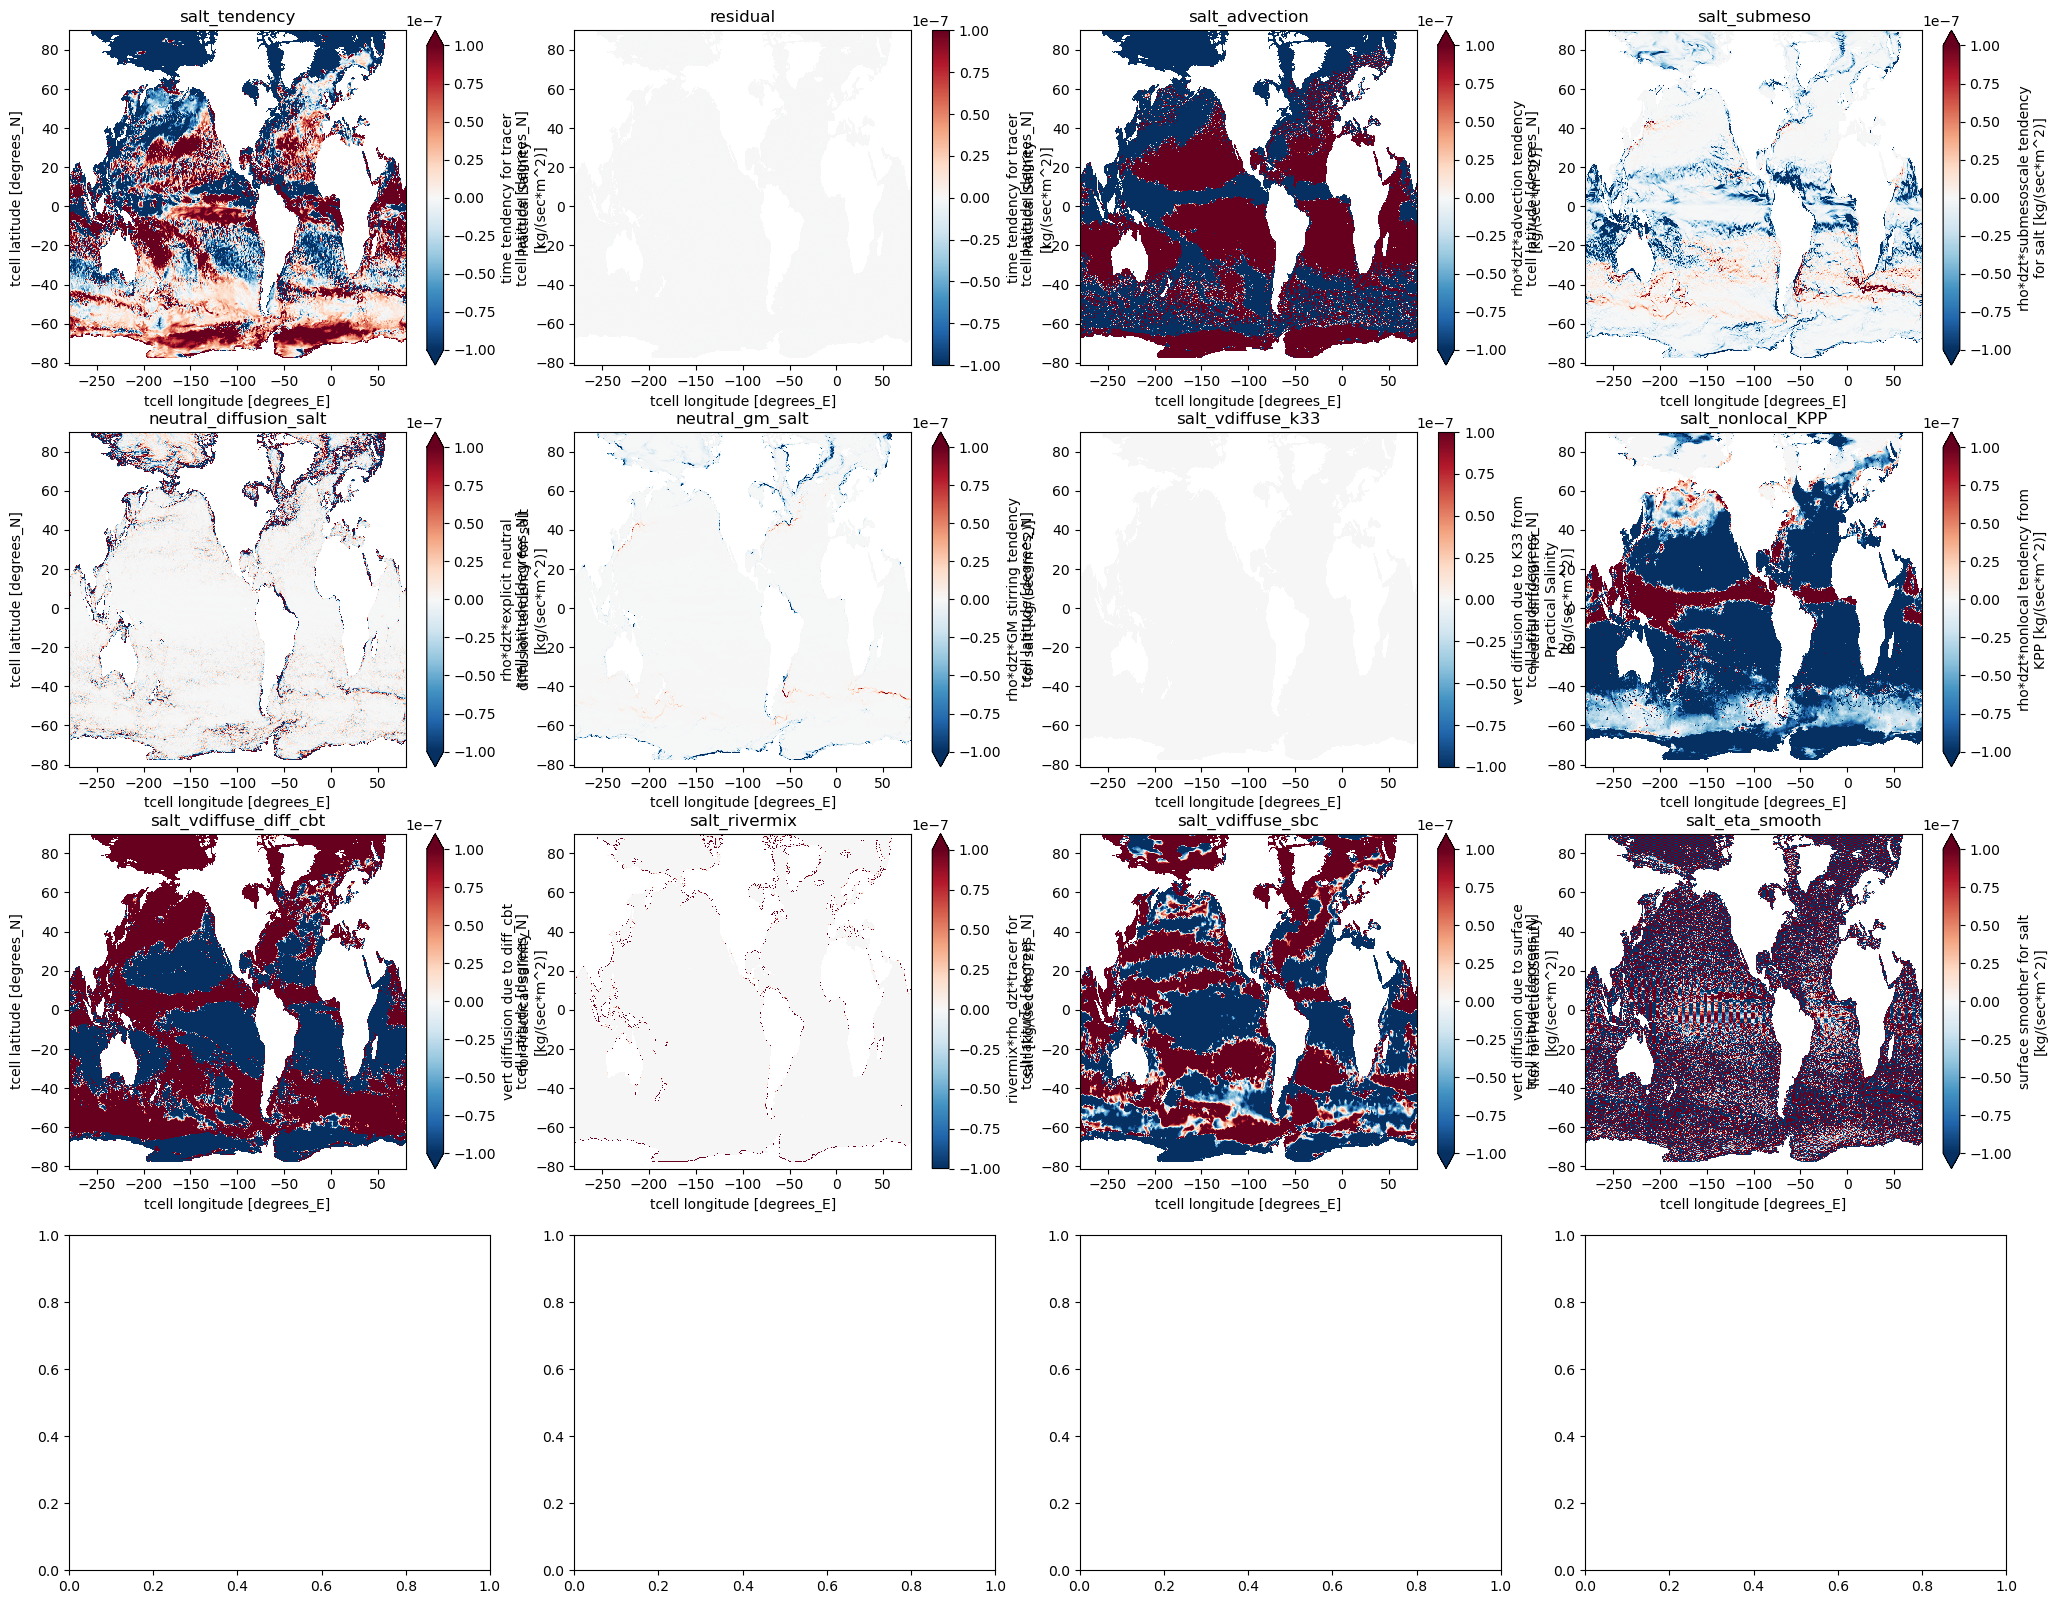

In [15]:
# Plot every term and print out the maximum of the absolute value of every term to confirm closure:
fig, axes = plt.subplots(nrows=3,ncols=4,figsize=(25,15))
axs = axes.reshape(-1)
print('Spatial maximums of terms (10^-7 kgm-2sec-1):')
for i, var in enumerate(bud_vars):
    ds_budget_slice[var].plot(ax=axs[i],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
    axs[i].set_title(var)
    print('%10.5f, ' % (abs(ds_budget_slice[var]).max().values*1.e7) + ' ' + var)


## Vertically-integrated salt budget:

In [7]:
# Choose time, region, depth:
time = 0; reg_slice= [-300, 300,-90,90];

# Load budget:
ds_budget_slice = xr.open_dataset(base2 + 'ocean_budget.nc').sel(xt_ocean=slice(reg_slice[0],reg_slice[1]),yt_ocean=slice(reg_slice[2],reg_slice[3])).isel(time=time)#.sum('st_ocean')

# List the terms:
bud_vars = ['salt_advection','salt_submeso','neutral_diffusion_salt','neutral_gm_salt','salt_vdiffuse_k33',
            'salt_nonlocal_KPP','salt_vdiffuse_diff_cbt',
            'salt_rivermix','salt_vdiffuse_sbc','salt_eta_smooth']

# Do vertical sum:
ds_budget_slice = ds_budget_slice[bud_vars + ['salt_tendency']].sum('st_ocean')

# Compute the residual:
ds_budget_slice['residual'] = ds_budget_slice.salt_tendency.load().copy(deep=True)
for var in bud_vars:
    ds_budget_slice['residual'] -= ds_budget_slice[var].load()

# Add tendency and residual to the terms list:
bud_vars = ['salt_tendency','residual'] + bud_vars

Spatial maximums of terms (10^-7 kgm-2sec-1):
3154.56273,  salt_tendency
   0.00166,  residual
3744.95576,  salt_advection
 100.34711,  salt_submeso
2564.44968,  neutral_diffusion_salt
 938.78312,  neutral_gm_salt
   0.00000,  salt_vdiffuse_k33
   0.00011,  salt_nonlocal_KPP
   0.00024,  salt_vdiffuse_diff_cbt
   0.00073,  salt_rivermix
  84.98965,  salt_vdiffuse_sbc
1146.74498,  salt_eta_smooth


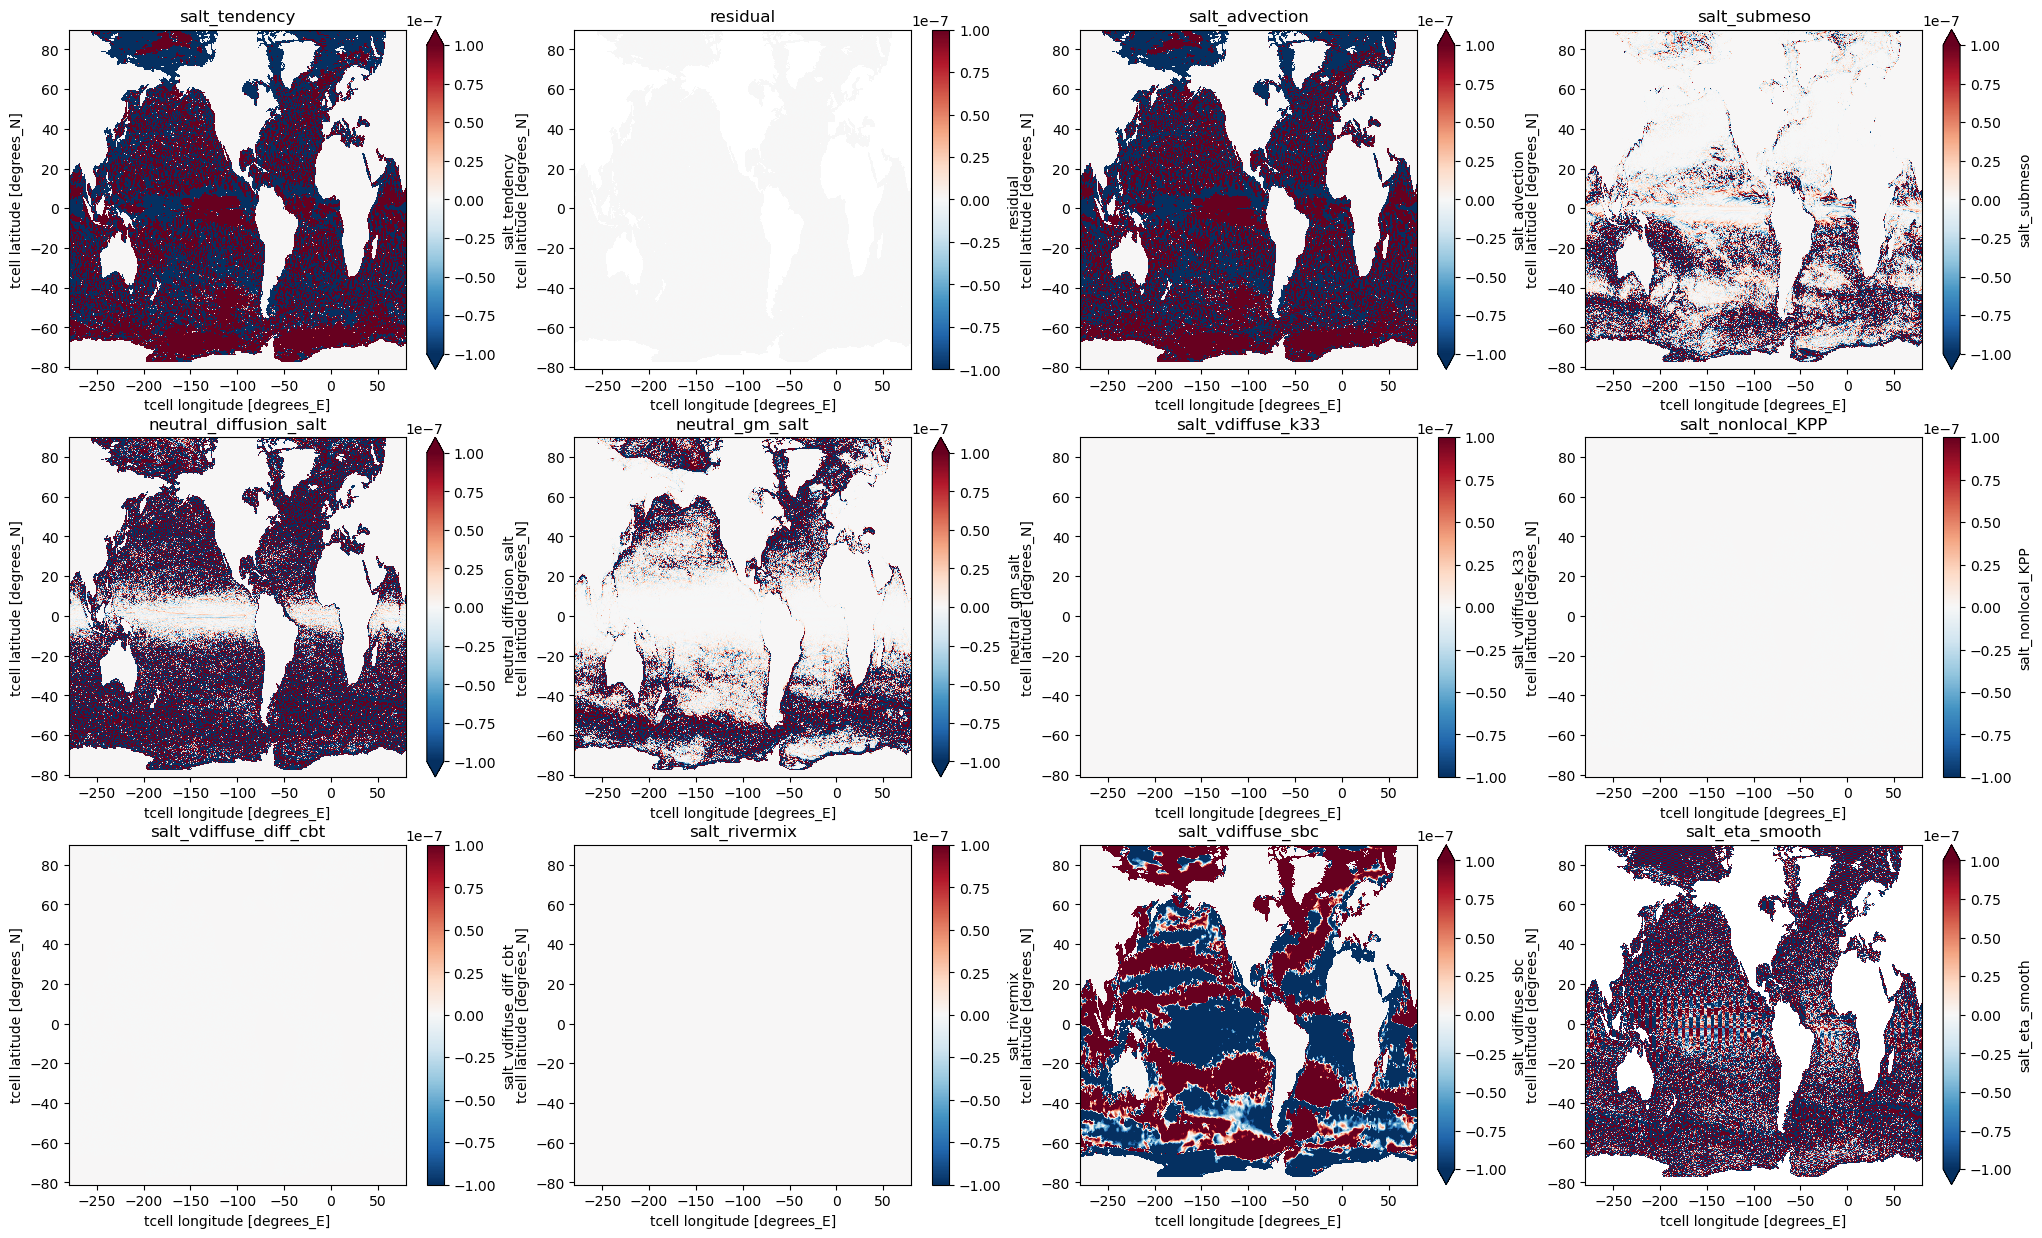

In [9]:
# Plot every term and print out the maximum of the absolute value of every term to confirm closure:
fig, axes = plt.subplots(nrows=3,ncols=4,figsize=(25,15))
axs = axes.reshape(-1)
print('Spatial maximums of terms (10^-7 kgm-2sec-1):')
for i, var in enumerate(bud_vars):
    ds_budget_slice[var].plot(ax=axs[i],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
    axs[i].set_title(var)
    print('%10.5f, ' % (abs(ds_budget_slice[var]).max().values*1.e7) + ' ' + var)

## Construct vertically-integrated salinity budget for one month:

In [90]:
# List the terms:
bud_vars = ['salt_advection','salt_submeso','neutral_diffusion_salt','neutral_gm_salt','salt_vdiffuse_k33',
            'salt_nonlocal_KPP','salt_vdiffuse_diff_cbt',
            'salt_rivermix','salt_vdiffuse_sbc','salt_eta_smooth']

# Do vertical sum:
ds_mon_budget_vint = ds_mon_budget[bud_vars + ['salt_tendency']].sum('st_ocean')

# Compute the residual:
ds_mon_budget_vint['residual'] = ds_mon_budget_vint.salt_tendency.load().copy(deep=True)
for var in bud_vars:
    ds_mon_budget_vint['residual'] -= ds_mon_budget_vint[var].load()

# Add tendency and residual to the terms list:
bud_vars = ['salt_tendency','residual'] + bud_vars

In [91]:
time = 0; reg_slice= [-300, 300,-90,90];
dzt = ds_month.dht.sel(xt_ocean=slice(reg_slice[0],reg_slice[1]),yt_ocean=slice(reg_slice[2],reg_slice[3])).isel(time=time)
salt = ds_month.salt.sel(xt_ocean=slice(reg_slice[0],reg_slice[1]),yt_ocean=slice(reg_slice[2],reg_slice[3])).isel(time=time)/1000. # Put in units of kg/kg
pme = ds_month.pme_river.sel(xt_ocean=slice(reg_slice[0],reg_slice[1]),yt_ocean=slice(reg_slice[2],reg_slice[3])).isel(time=time)/rho0
#salt_snap = ds_mon_snapshot.salt.sel(xt_ocean=slice(reg_slice[0],reg_slice[1]),yt_ocean=slice(reg_slice[2],reg_slice[3]))#.isel(time=time) # Currently missing salinity snapshots - so I won't plot the salinity tendency for now.
dzt_snap =  ds_mon_snapshot.dzt.sel(xt_ocean=slice(reg_slice[0],reg_slice[1]),yt_ocean=slice(reg_slice[2],reg_slice[3])).isel(time=slice(time,2))#.isel(time=time)

In [92]:
total_z = dzt.sum('st_ocean')
divisor = 1./total_z/rho0
Sbar = (salt*dzt).sum('st_ocean')/total_z

# Compute eta tendency from snapshots:
eta_tendency = xr.zeros_like(pme).copy(deep=True)
eta_tendency.data = (dzt_snap.isel(time=1).sum('st_ocean').values-dzt_snap.isel(time=0).sum('st_ocean').values)
eta_tendency = eta_tendency/(ds_month.average_DT / np.timedelta64(1, 's'))
divU = eta_tendency - pme

# Convert budget units:
ds_mon_budget_vint = divisor*ds_mon_budget_vint

# Add additional terms:
ds_mon_budget_vint['PME'] = -Sbar/total_z*pme
ds_mon_budget_vint['salt_advection'] += -Sbar/total_z*divU
bud_vars += ['PME']

Text(0.5, 1.0, 'Eta tendency')

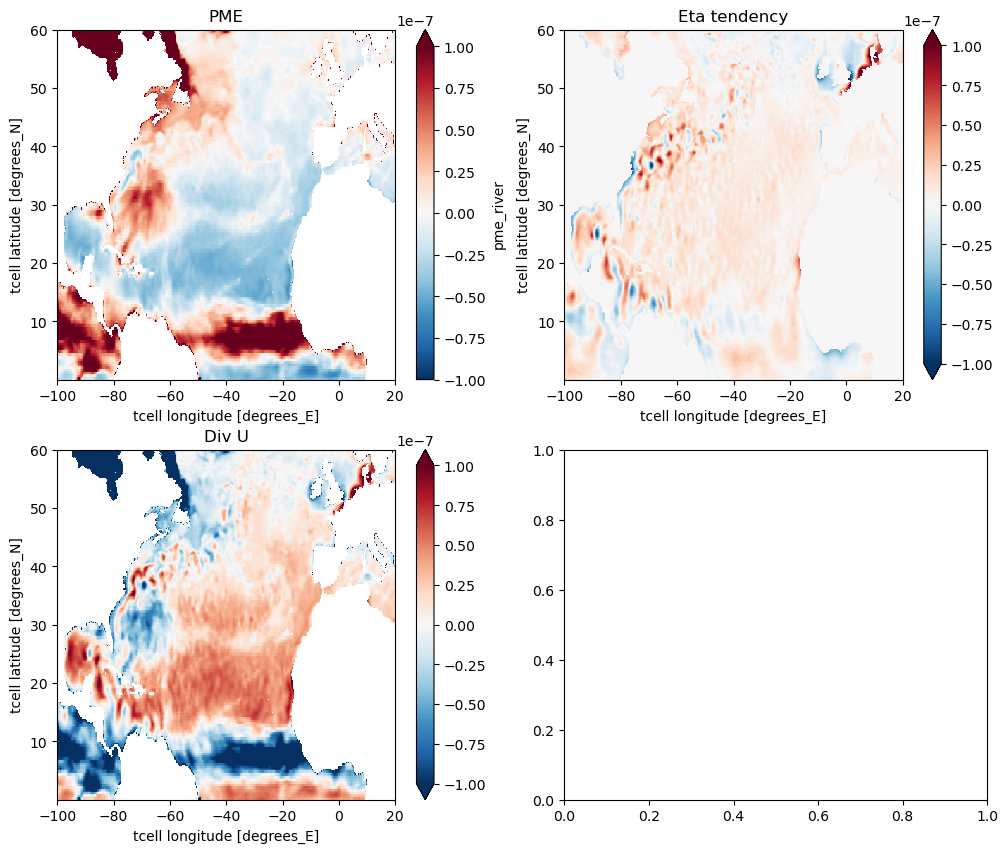

In [93]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
pme.plot(ax=axes[0][0],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axes[0][0].set_title('PME')
divU.plot(ax=axes[1][0],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axes[1][0].set_title('Div U')
eta_tendency.plot(ax=axes[0][1],vmin=-1.e-7,vmax=1.e-7,cmap='RdBu_r')
axes[0][1].set_title('Eta tendency')

Spatial maximums of terms (kg/kg 10^-10 sec-1):
  33.22468,  salt_tendency
   0.00002,  residual
 281.03123,  salt_advection
   0.53360,  salt_submeso
  88.56546,  neutral_diffusion_salt
   1.88424,  neutral_gm_salt
   0.00000,  salt_vdiffuse_k33
   0.00000,  salt_nonlocal_KPP
   0.00001,  salt_vdiffuse_diff_cbt
   0.00001,  salt_rivermix
   3.49502,  salt_vdiffuse_sbc
  77.23218,  salt_eta_smooth
 366.64172,  PME


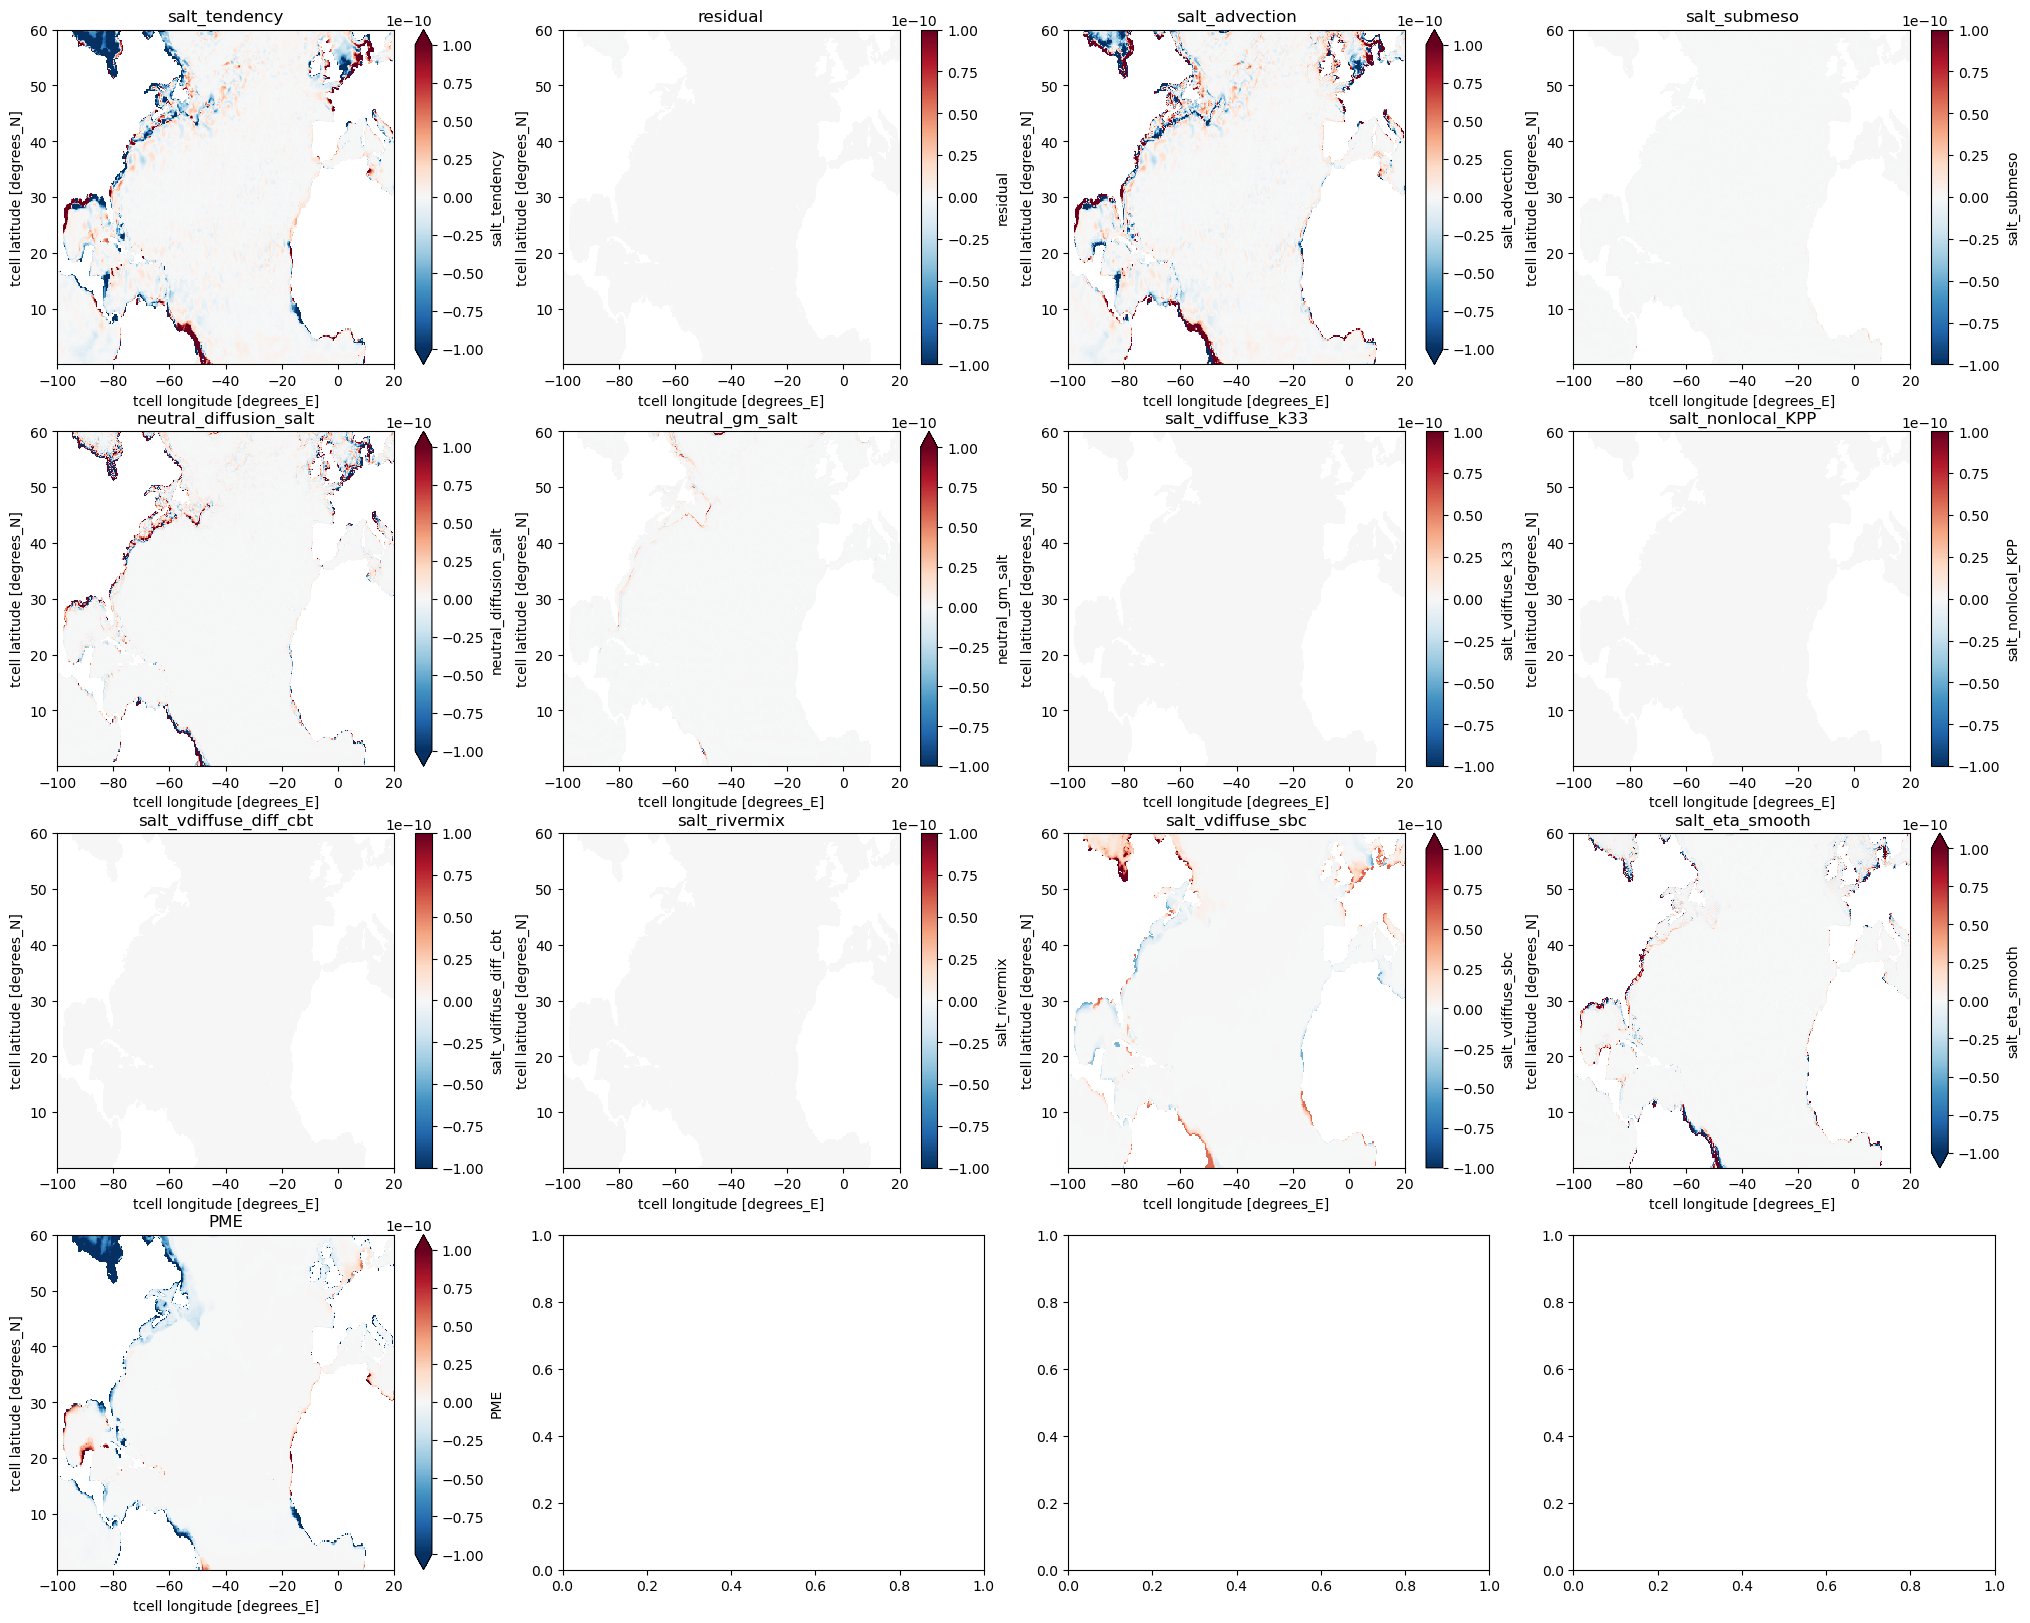

In [95]:
# Plot every term and print out the maximum of the absolute value of every term to confirm closure:
fig, axes = plt.subplots(nrows=4,ncols=4,figsize=(25,20))
axs = axes.reshape(-1)
print('Spatial maximums of terms (kg/kg 10^-10 sec-1):')
for i, var in enumerate(bud_vars):
    ds_mon_budget_vint[var].plot(ax=axs[i],vmin=-1.e-10,vmax=1.e-10,cmap='RdBu_r')
    axs[i].set_title(var)
    print('%10.5f, ' % (abs(ds_mon_budget_vint[var]).max().values*1.e10) + ' ' + var)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
axs = axes.reshape(-1)

# Select budget and convert units
#budget = mon_budget_in_mld*86400*30.5 # Average May-July and convert from degC s-1 to degC/month
#pre_label = 'Monthly Offline '
budget = day_budget_in_mld*86400*30.5 # Average May-July and convert from degC s-1 to degC/month
pre_label = 'Daily Offline '
#budget = online_budget_in_mld.mean('time')*86400*30.5 # Average May-July and convert from degC s-1 to degC/month
#pre_label = 'Online '

vars
clim = 3.
for i, var in enumerate(list(budget.data_vars)):
    budget[var].plot(ax=axs[i],cmap='RdBu_r',vmin=-clim,vmax=clim,extend='both')#,vmax=0.001)#vmin=-0.1,vmax=0.1) 
    axs[i].set_title(pre_label + var)
# Note: Make the color limits much smaller and look at "residual" to see that it closes. Although, of course, you can't 
# check that the mlh_tendency and entrainment calculations close since they are done by residual.

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_facecolor('k')
plt.tight_layout()
plt.savefig('daily_mlt_lin_budget_Atlantic_Jun_2023.png',dpi=150)